# 19기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

# 1. Preprcessing / EDA

## 1-1 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1-2 데이터 설명

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [3]:
df.shape

(200, 4)

In [4]:
uniq_count = {} # 각 변수당 unique한 데이터 수
for i in df.columns:
    uniq_count[i] = df[i].nunique()
uniq_count

{'Gender': 2,
 'Age': 51,
 'Annual Income (k$)': 64,
 'Spending Score (1-100)': 84}

In [5]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [6]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

데이터의 정보를 살펴보도록 한다.  


총 4개의 변수들(customer ID = index 번호)

* Gender : 성별
* Annual Income : 소득
* Spending Score : 쇼핑몰에서 부여한 고객 점수(1~100)  
  
이 존재하며 200개의 데이터들이 존재한다.  
이 데이터셋은 쇼핑몰에서의 고객 성별정보와 소득 그리고 고객의 점수로 구성되어 있으므로 Income과 Score을 통해서 적절히 군집화가 가능해보인다.

이후 각 변수들의 type을 살펴보면  

* object(범주형) - 'Gender' 
* int(수치형) - 'Annual Income', 'Spending Score'

로 이루어져 있음을 확인할 수 있다.
또한 모든 변수에 대해 결측치가 존재하지 않는 것도 확인할 수 있다.

## 1-3 변수 시각화

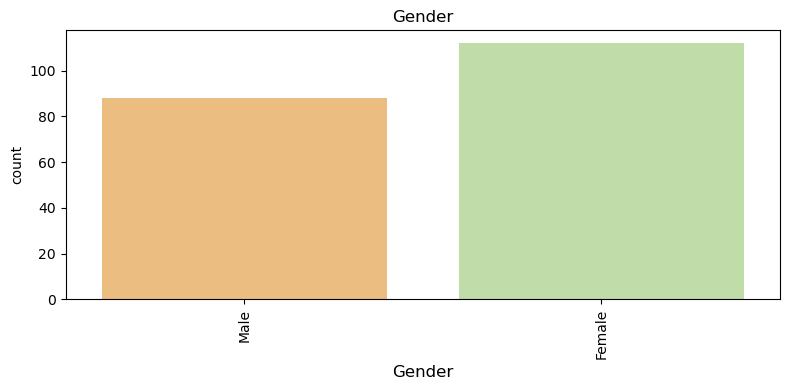

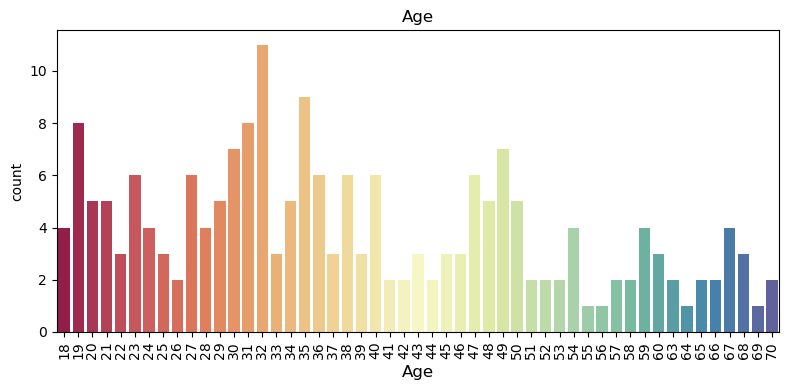

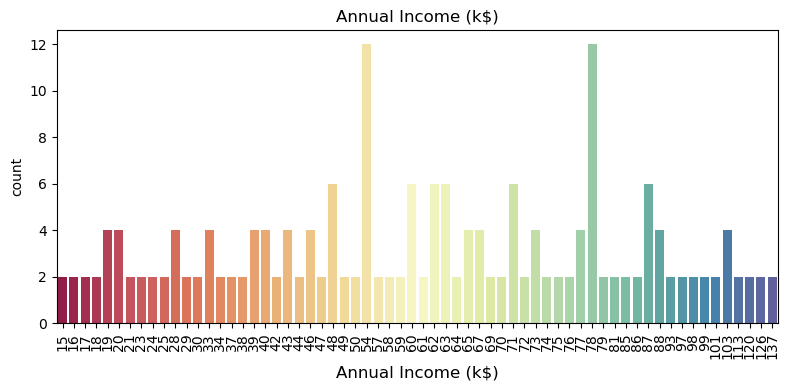

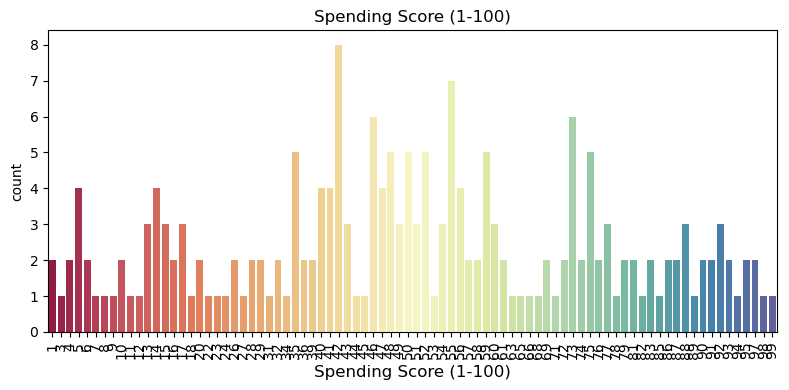

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for i, col in enumerate(list(df.columns)): # 변수 column별 countplot을 그려주는 함수
    plt.figure(figsize=(8,4))
    sns.countplot(x = col, data = df, palette="Spectral")
    plt.title(col)
    plt.xticks(rotation = 90)
    plt.xlabel(col, size = 12)
    plt.tight_layout()

우선 각 변수들의 분포를 알아보도록 한다.  
* 범주형 변수에 해당하는 성별은 Male과 Female에서 여성의 count가 조금 더 높게 나타난다.
* 소득과 점수에 대해서는 그 분포가 다양하게 나타난다.

이후 numerical 변수들인 income과 score에 대한 pairplot을 이용해 변수간 관계를 알아보도록 한다.

<Figure size 1000x800 with 0 Axes>

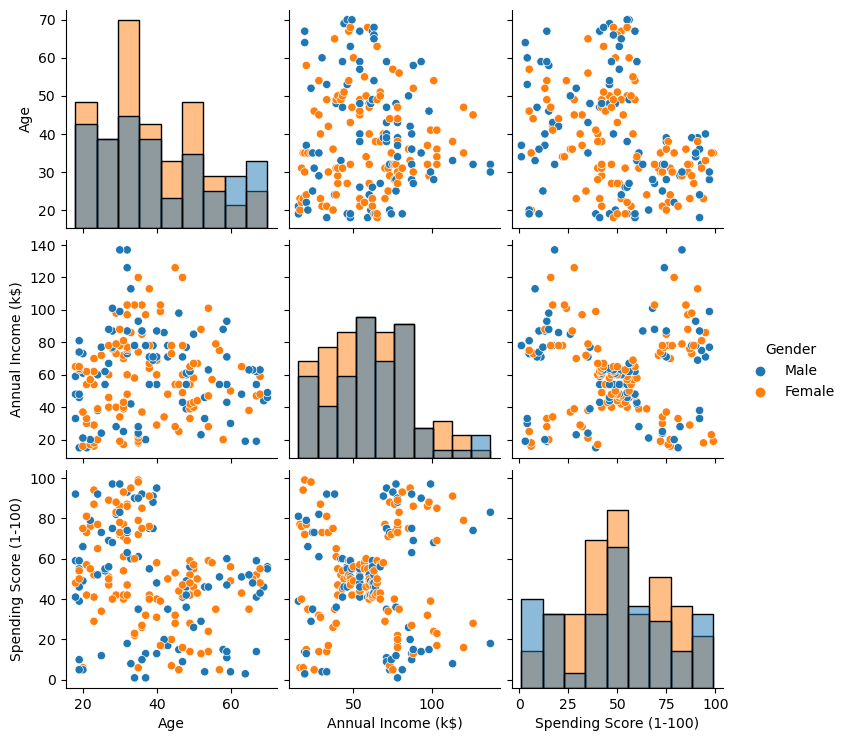

In [8]:
plt.figure(figsize=(10,8))
sns.pairplot(df, diag_kind = 'hist', hue = 'Gender') # pairplot 생성
plt.show()

두 수치형 변수에 대한 pairplot을 살펴보면 Income과 Score의 산점도를 보았을 때 5가지 정도의 군집을 형성할만한 분포를 가지고 있음을 알 수 있다.
따라서 이후 분석에 있어서 두 변수를 중점으로 군집화를 진행하기로 판단하였다.

**5가지의 군집을 나누는 경우** 

1. 소득과 점수가 모두 높은 군집
2. 소득과 점수가 모두 낮은 군집
3. 소득과 점수가 중간 수준인 군집
4. 소득은 높으면서 점수가 낮은 군집
5. 소득은 낮으면서 점수가 높은 군집

## 1-4 범주형 변수 처리(One_Hot_Encoding)

성별의 경우 Male, Female 2개의 범주로 이루어져 있기 때문에 이를 one-hot-encoding을 통해 변형시켜준다.

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe_fit = ohe.fit(df[['Gender']])

ohe_encoded = ohe_fit.transform(df[['Gender']]).toarray()

ohe_df = pd.DataFrame(ohe_encoded, index = df.index, columns = ohe_fit.get_feature_names(['Gender']))
df_1 = pd.concat([ohe_df, df], axis = 1).drop(['Gender'], axis=1) # 'Gender'에 대해 one-hot-encoding을 한 후 다시 하나의 데이터프레임으로 만들어줌
df_1

,Gender_Female,Gender_Male,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,,
1,0.0,1.0,19,15,39
2,0.0,1.0,21,15,81
3,1.0,0.0,20,16,6
4,1.0,0.0,23,16,77
5,1.0,0.0,31,17,40
...,...,...,...,...,...
196,1.0,0.0,35,120,79
197,1.0,0.0,45,126,28
198,0.0,1.0,32,126,74


In [10]:
data = df_1[['Annual Income (k$)', 'Spending Score (1-100)']]
data

,Annual Income (k$),Spending Score (1-100)
CustomerID,,
1,15,39
2,15,81
3,16,6
4,16,77
5,17,40
...,...,...
196,120,79
197,126,28
198,126,74


이후 두 변수(Income, Score)에 대한 군집화를 위해 두 변수만을 가져온 data를 만들어준다.

## 1-5 변수 scaling

Income과 Score는 서로 다른 범위를 가지므로 해당 변수들을 적절히 scaling을 통해 변환시켜준다.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)

data = pd.DataFrame(scaler.transform(data))
data

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


# 2. Clustering 

## 2-1 Hierarchical Clustering

먼저 Hierarchical Clustering 즉, 계층적 군집화를 진행해 보았다. 덴드로그램을 통해 시각화해보면서 군집이 잘 형성되는지 확인해볼 수 있다.

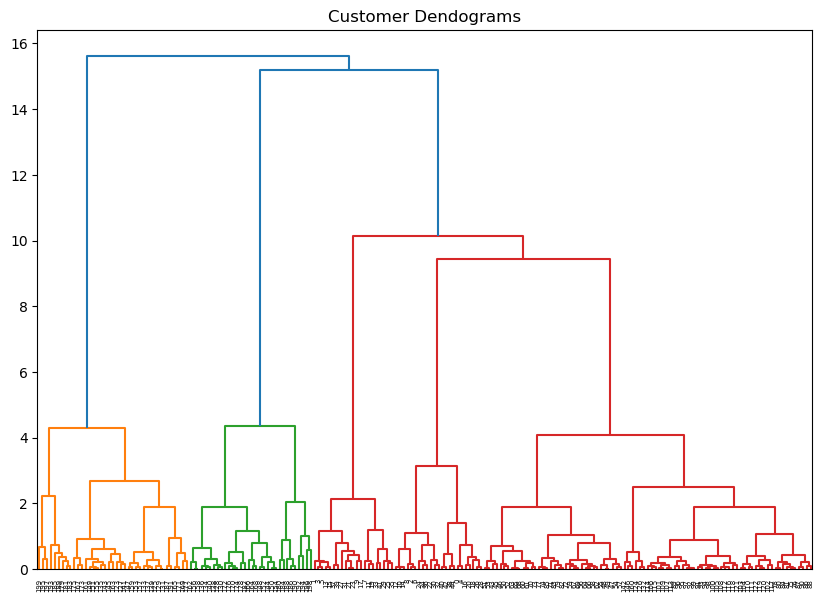

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = dendrogram(linkage(data, method = 'ward'))
plt.show()

먼저 덴드로그램을 통해 200개의 데이터에서 출발하여 위로 올라가면서 적절히 군집이 형성됨을 확인할 수 있다.  
계층적 군집화에서는 하이퍼파라미터로 군집간의 거리, 클러스터와 관측치와의 거리를 계산하는 기준을 의미하는 method가 존재하는데 위에서는 ward distance를 활용해 구하였다.

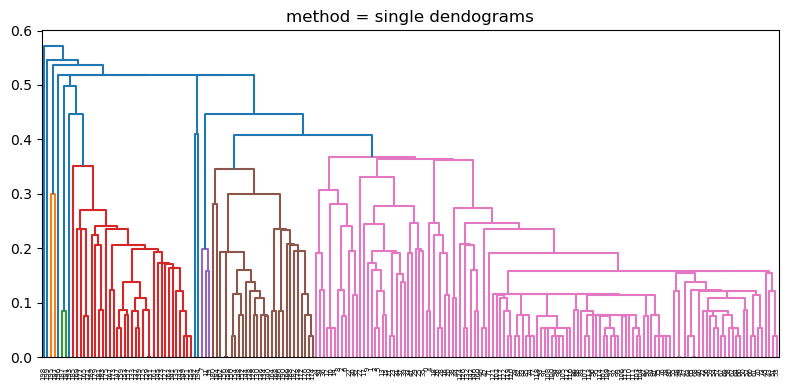

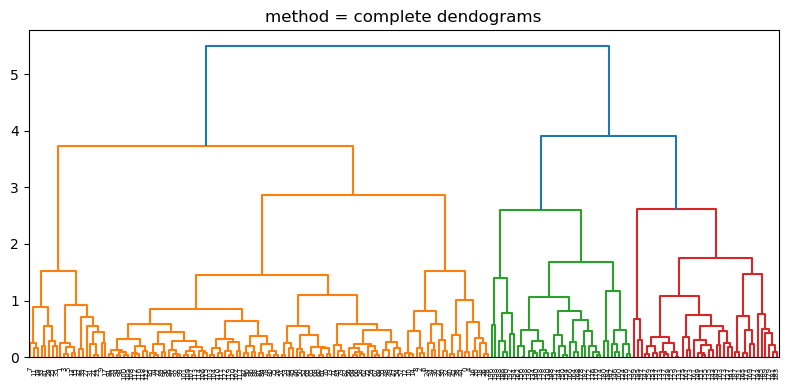

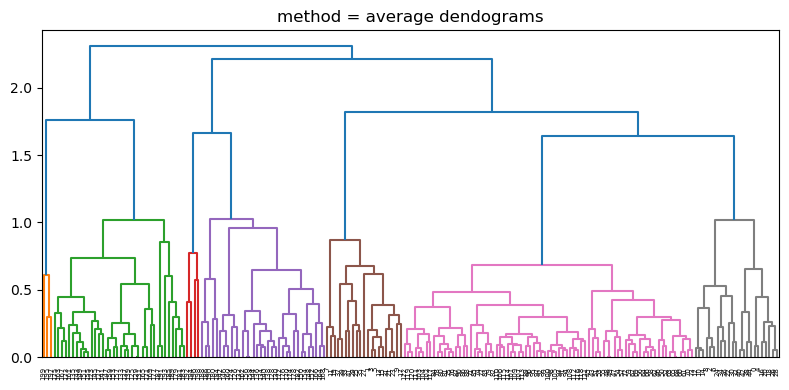

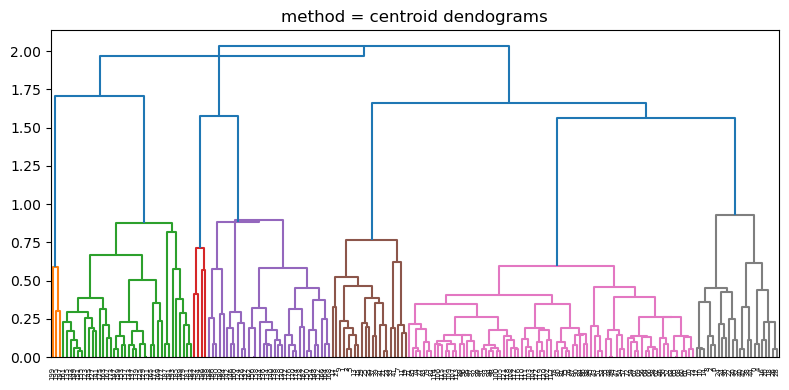

In [13]:
from itertools import product

d_list = ['single','complete','average','centroid'] # 서로다른 method에 따른 덴드로그램 형성

for i in range(len(d_list)):               
    plt.figure(figsize=(8,4))
    plt.title("method = {0} dendograms".format(d_list[i]))
    plt.xticks(rotation = 45)
    dend = dendrogram(linkage(data, method = d_list[i]))
    plt.tight_layout()

추가적으로 군집간의 거리로 single, complete, average, centroid가 존재한다.  
따라서 이러한 파라미터를 조정하여 다른 distance에 대해서도 덴드로그램을 그려보았다.

다음으로 method를 바꾸어가며 data의 산점도를 그려보았다.

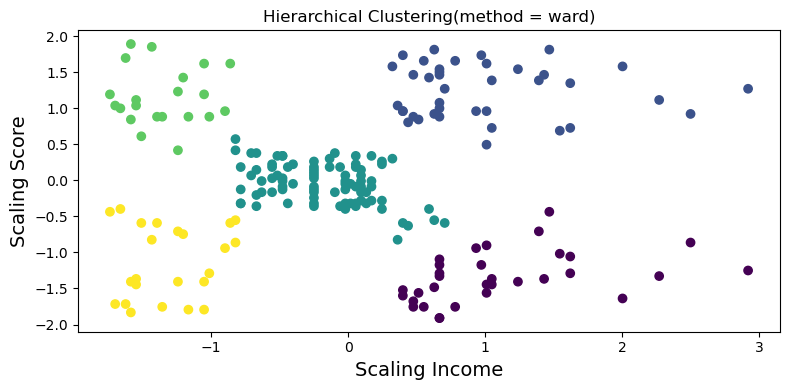

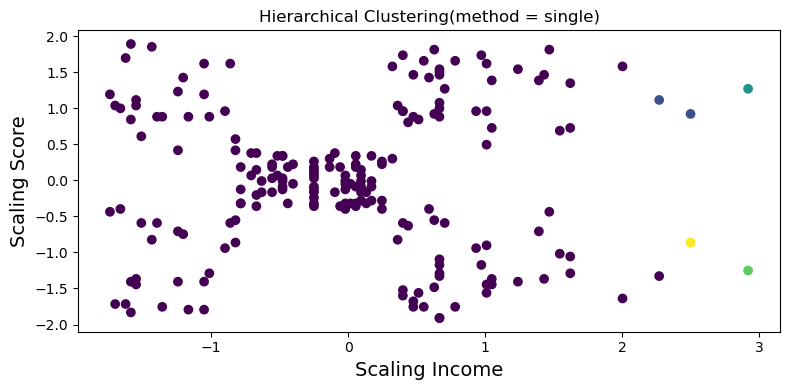

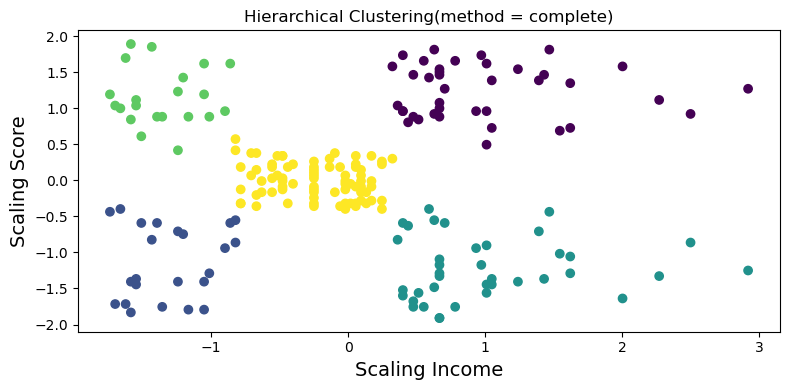

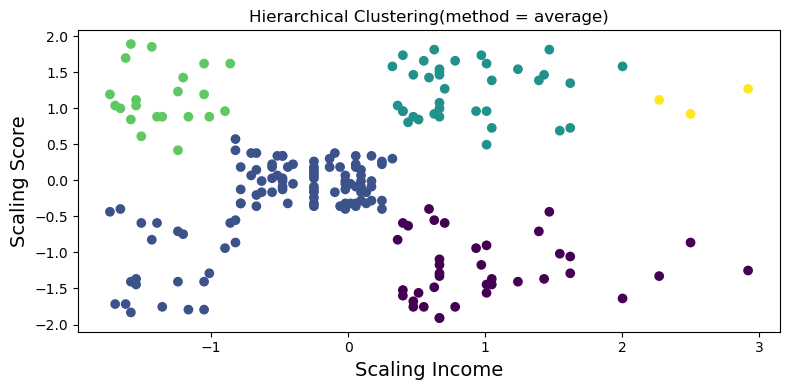

In [14]:
from sklearn.cluster import AgglomerativeClustering

m_list = ['ward','single','complete','average'] # 서로다른 method에 따른 산점도 형성

for i in m_list:
    model = AgglomerativeClustering(n_clusters = 5, linkage = i)
    cluster = model.fit_predict(data)

    plt.figure(figsize=(8,4))
    plt.scatter(data[0], data[1], c = cluster)
    plt.title('Hierarchical Clustering(method = {0})'.format(i))
    plt.xlabel('Scaling Income',fontsize=14)
    plt.ylabel('Scaling Score',fontsize=14)
    plt.tight_layout()

위의 결과를 비교해보면 ward와 complete를 method로 하였을 때의 5개 군집으로 적절히 분류됨을 확인할 수 있다.  
반면에 single의 경우에는 하나의 군집에 몰려있는 모습이 나타나고 average에서는 5개보다는 4개의 군집에 더 가깝게 나타남을 확인할 수 있다.

## 2-2 K-Means Clustering

k-means clustering 즉, k-평균 군집화는 가장 대표가 되는 군집화 알고리즘으로 사전에 군집의 수 k가 정해진 후에 실행되는 알고리즘이다.  
각 개체별로 가장 가까운 중심에 할당되며, 같은 중심에 할당되 개체들이 모여 하나의 군집이 형성되고 최종 k개의 군집을 형성하게 된다.

K(군집)의 개수를 정하는 방법으로 2가지가 있다.
1. Elbow Method : 군집 내 편차제곱합(WSS)이 최소가 되도록 군집의 중심 결정, 급격하게 감소하기 시작하는 K 선택
2. Silhouette Coefficient : 군집 내 특정 데이터와 같은 군집의 다른 데이터와의 유사성을 통해 다른 군집의 데이터들과의 차이를 측정, (-1, 1)의 값을 가지며 1에 가까울수록 적절히 군집화가 되었다고 판단

### 2-2-1 Elbow Method

KElbowVisualizer(ax=<AxesSubplot: >, estimator=KMeans(n_clusters=9), k=(1, 10))

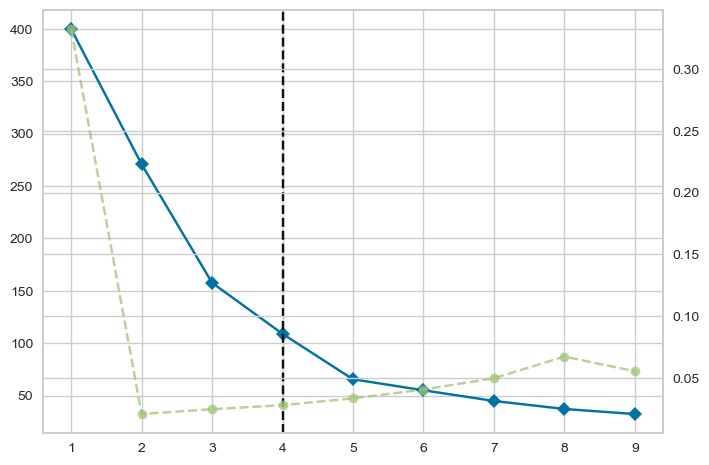

In [15]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data)

Elbow Method를 이용한 결과 초기 중심 k의 개수를 4로 추천해주고 있다. 따라서 k를 4와 그 근처인 3, 5정도로 초기 중심을 추려볼 수 있다.

### 2-2-2 Silohuette score

In [16]:
from sklearn.metrics import silhouette_score

for i in range(2, 10):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit_predict(data)
        cluster = kmeans.predict(data)
        score = silhouette_score(data, cluster)

        print("군집 수 : {0}, 실루엣 점수 : {1}".format(str(i), str(round(score,3)))) # 각 군집수에 따른 실루엣 점수 출력

군집 수 : 2, 실루엣 점수 : 0.315
군집 수 : 3, 실루엣 점수 : 0.467
군집 수 : 4, 실루엣 점수 : 0.494
군집 수 : 5, 실루엣 점수 : 0.555
군집 수 : 6, 실루엣 점수 : 0.54
군집 수 : 7, 실루엣 점수 : 0.528
군집 수 : 8, 실루엣 점수 : 0.457
군집 수 : 9, 실루엣 점수 : 0.458


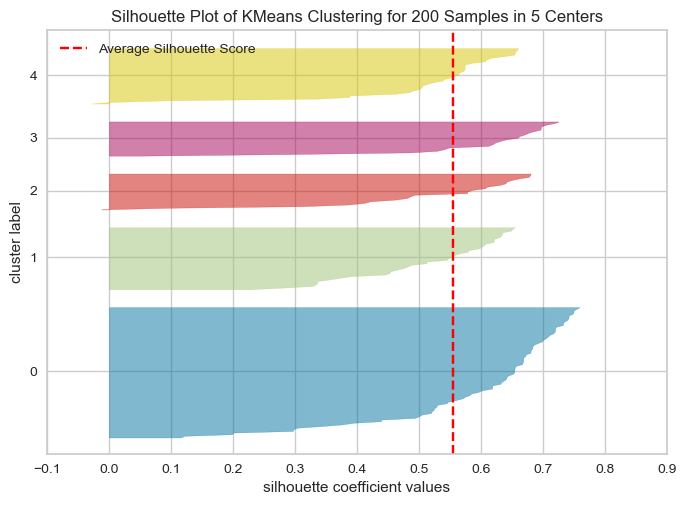

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 200 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(n_clusters = 5)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer.fit(data)      
visualizer.show()

앞서 Elbow Method로 군집의 수가 3,4,5정도일 때가 적절하다고 판단할 수 있었다. 이어서 두번째 방법인 실루엣 계수를 확인해보면 그중에서 k=5일 때 0.55로 가장 높은 계수값을 얻을 수 있다.  
따라서 이후의 K-Means Clustering에서 k값을 5로 설정하여 진행하도록 한다.

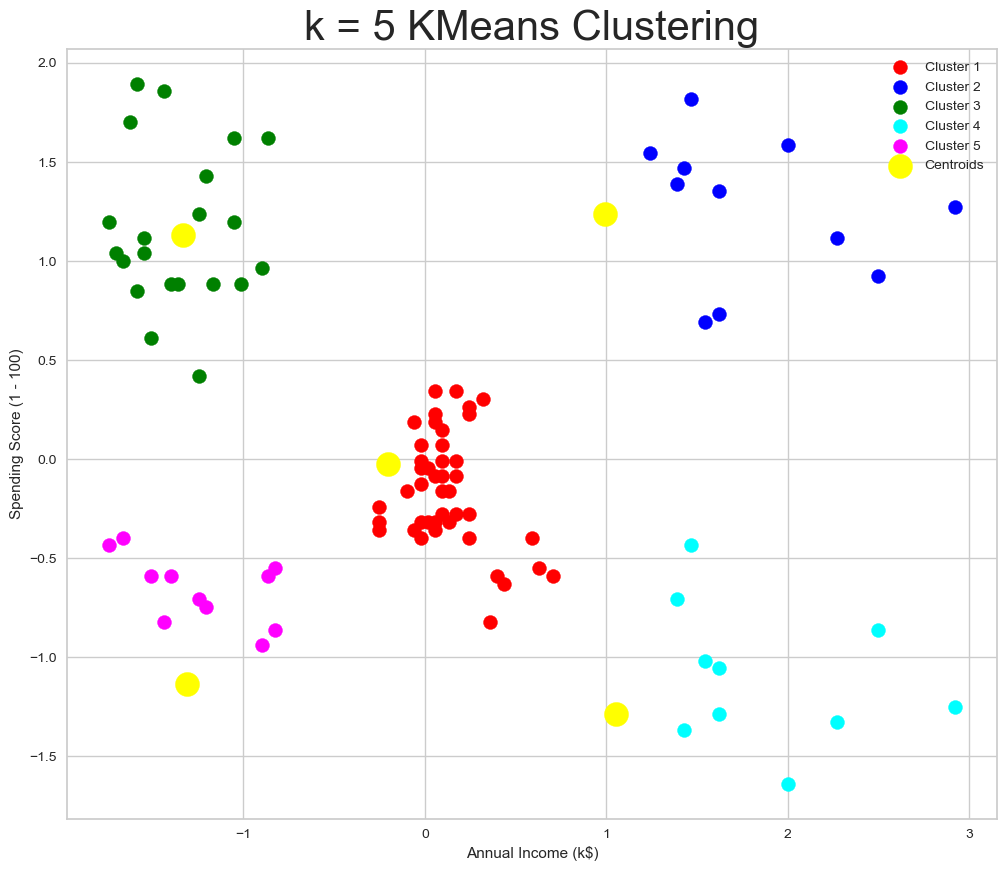

In [18]:
plt.figure(figsize=(12, 10))
plt.scatter(data[cluster == 0][0], data[cluster == 0][1], s= 100, c = 'red', label = 'Cluster 1')
plt.scatter(data[cluster == 1][0], data[cluster == 1][1], s= 100, c = 'blue', label = 'Cluster 2')
plt.scatter(data[cluster == 2][0], data[cluster == 2][1], s= 100, c = 'green', label = 'Cluster 3')
plt.scatter(data[cluster == 3][0], data[cluster == 3][1], s= 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(data[cluster == 4][0], data[cluster == 4][1], s= 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:,1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('k = 5 KMeans Clustering', fontsize = 30)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1 - 100)')
plt.legend()
plt.show()

k가 5일 때 clustering 결과를 보면 적절히 잘 군집을 형성했다고 볼 수 있다.

## 2-3 DBSCAN Clustering

K-Means는 서로 다른 밀도의 군집을 잘 찾아내기 어렵다. 이러한 단점을 보완하기 위한 방법으로 DBSCAN Clustering 알고리즘이 있다.  
이는 공간상에 높은 밀도를 가지고 모여있는 관측치들을 하나의 그룹으로 간주하고, 낮은 밀도를 가지고 홀로 있는 관측치는 이상치 혹은 잡음으로 분류하는 밀도기반 군집화 방법이다.  
이 알고리즘 역시 따로 군집의 개수를 미리 지정할 필요는 없고 노이즈 데이터의 분류를 통해 군집화의 성능 저하를 완화시켜줄 수 있다.  

하이퍼 파라미터 종류 2가지
* eps(epsilon) : 특정 데이터에 대해 같은 군집이라고 판단할 수 있는 주변 데이터까지의 거리
* min_samples : 한 군집 내 최소 데이터 수

In [108]:
from sklearn.cluster import DBSCAN

dbscan_df = data.copy()

model = DBSCAN(min_samples = 4)
dbscan_df['cluster'] = model.fit_predict(dbscan_df)

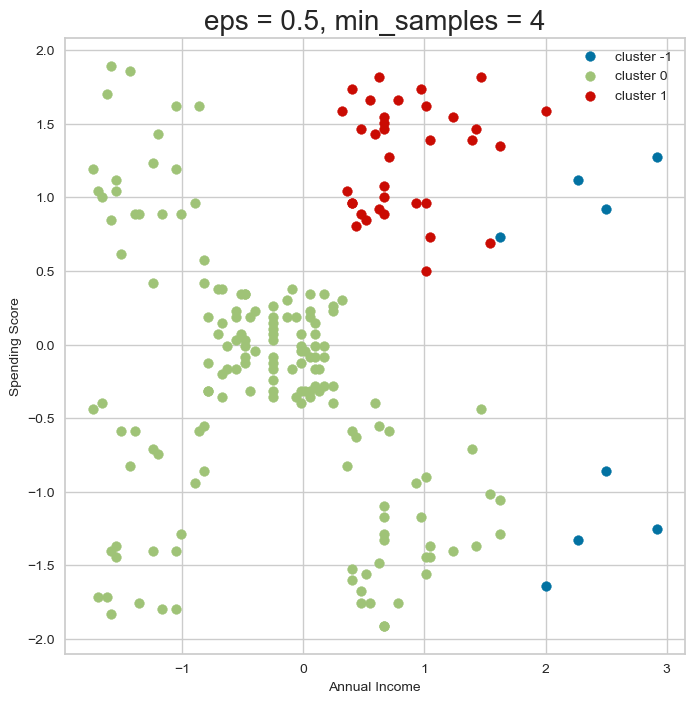

In [112]:
plt.figure(figsize = (8, 8))

# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
for i in range(-1, dbscan_df['cluster'].max() + 1):
    plt.scatter(dbscan_df.loc[dbscan_df['cluster'] == i, 0], dbscan_df.loc[dbscan_df['cluster'] == i, 1], 
                    label = 'cluster ' + str(i))

plt.legend()
plt.title('eps = 0.5, min_samples = 4', size = 20)
plt.xlabel('Annual Income', size = 10)
plt.ylabel('Spending Score', size = 10)
plt.show()

2개의 변수(Income, Score)에 대한 데이터이므로 2차원 데이터이다. 따라서 통상적으로 2차원 데이터에 한에서는 min_samples를 4로 설정하기 때문에 이에 대한 DBSCAN Clustering plot을 그려보았다.  
cluster -1은 이상치에 해당하는 점들이고 총 2개의 군집으로 분류하였음을 확인할 수 있다.  

기존의 Hierarchical와 KMeans에서 설정한 5개의 군집과는 다른 결과를 보였으므로 적절한 군집형성이라고 볼 수 없다. 따라서 하이퍼파라미터를 적절히 수정하면서 그 결과를 다시한번 살펴보도록 한다.

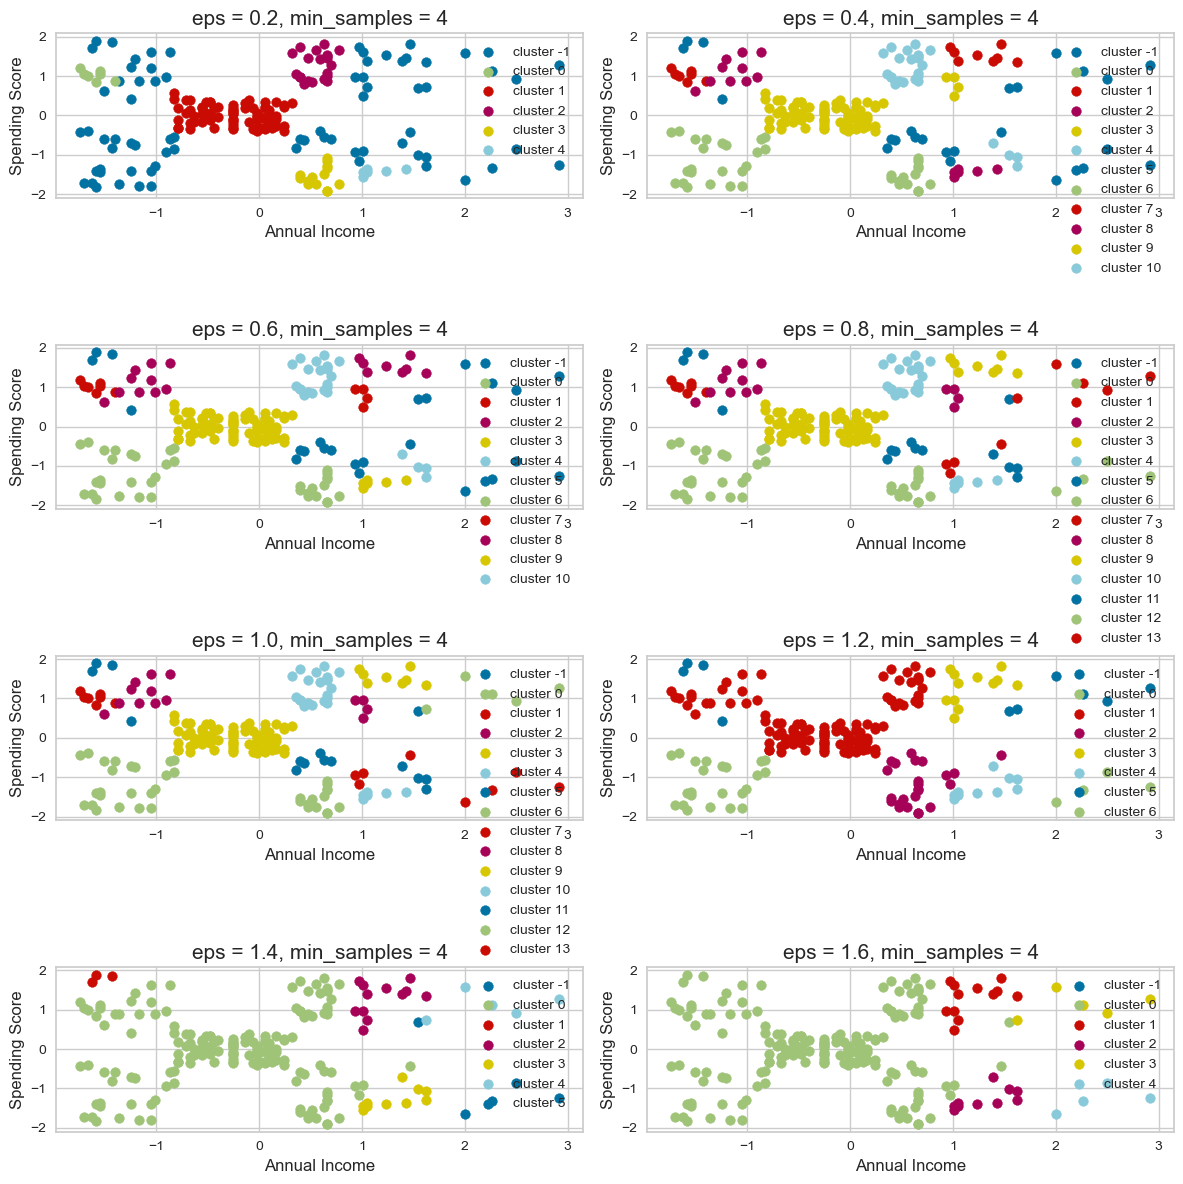

In [119]:
f, ax = plt.subplots(4, 2)
f.set_size_inches((12, 12))

for i in range(8):
    # epsilon을 증가시키면서 반복
    eps = 0.2 * (i + 1)
    min_samples = 4

    # 군집화 및 시각화 과정 자동화
    model = DBSCAN(eps=eps, min_samples=min_samples)

    model.fit(dbscan_df)
    dbscan_df['cluster'] = model.fit_predict(dbscan_df)

    for j in range(-1, dbscan_df['cluster'].max() + 1):
        ax[i // 2, i % 2].scatter(dbscan_df.loc[dbscan_df['cluster'] == j, 0], dbscan_df.loc[dbscan_df['cluster'] == j, 1], 
                        label = 'cluster ' + str(j))

    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('eps = %.1f, min_samples = %d'%(eps, min_samples), size = 15)
    ax[i // 2, i % 2].set_xlabel('Annual Income', size = 12)
    ax[i // 2, i % 2].set_ylabel('Spending Score', size = 12)
plt.tight_layout()
plt.show()

동일하게 min_samples를 4로 지정한 후 eps값을 0.2에서 0.2씩 높여가면서 plot을 그려보았다. 위의 그래프를 통해 결과를 나름 해석해보았다.  
  
* 매개변수를 매우 작게한 0.2에서는 이상치 즉, cluster-1에 해당하는 잡음 포인트들이 많음을 확인할 수 있다.  
* 높은 eps값일수록 어느정도 거리가 있는 점들끼리도 같은 군집에 포함하여 총 cluster의 개수에 비해 plot에 표현된 주요 cluster의 개수는 2~3개정도로 나타난다.
* 그래도 낮은 eps에서 좀더 나은 군집 형성을 볼 수 있다.

이후에는 min_samples 값을 변경해가면서 가장 5개의 군집을 잘 형성할 때의 plot을 찾아보도록 하였다.  
그리고 이때 앞서 min_samples의 값이 4일때의 결과와 DBSCAN Clustering의 작동절차를 적절히 이해하여 min_samples를 수정하였다.

**DBSCAN의 작동 원리**
1. 랜덤으로 데이터 포인트 설정
2. 해당 포인트에서 eps 거리 안의 모든 포인트 찾음  
    2-1. N(eps 거리 안의 데이터) < min_samples : 잡음 포인트로 레이블  
    2-2. N(eps 거리 안의 데이터) > min_samples : 핵심 포인트로 레이블하고 새로운 클러스터 레이블 할당
3. 핵심 포인트의 eps 거리 안의 모든 이웃 살핌  
    3-1. 어떤 클러스터에도 아직 할당되지 않았다면 바로 전에 만든 클러스터 레이블에 할당  
    3-2. 만약 핵심 샘플이면 그 포인트의 이웃을 차례로 방문

이러한 과정을 거치기 때문에 결국 매개변수 eps와 min_samples의 설정에 따라 cluster의 수가 정해지고 잡음 포인트의 수 역시도 결정된다.  
위의 min_samples가 4인 경우에도 상당히 많은 cluster 개수가 나타났고 이를 줄일수록 min_samples 값보다 큰 N이 많아지므로 더 많은 cluster의 수가 발생하게 된다. 따라서 min_samples를 4보다 큰 6, 8, 10, 12 4가지 경우에서 plot을 살펴보도록 하였다.(5개정도의 적절한 군집화가 된 경우를 찾으므로)

### 2-3-1 min_samples = 6

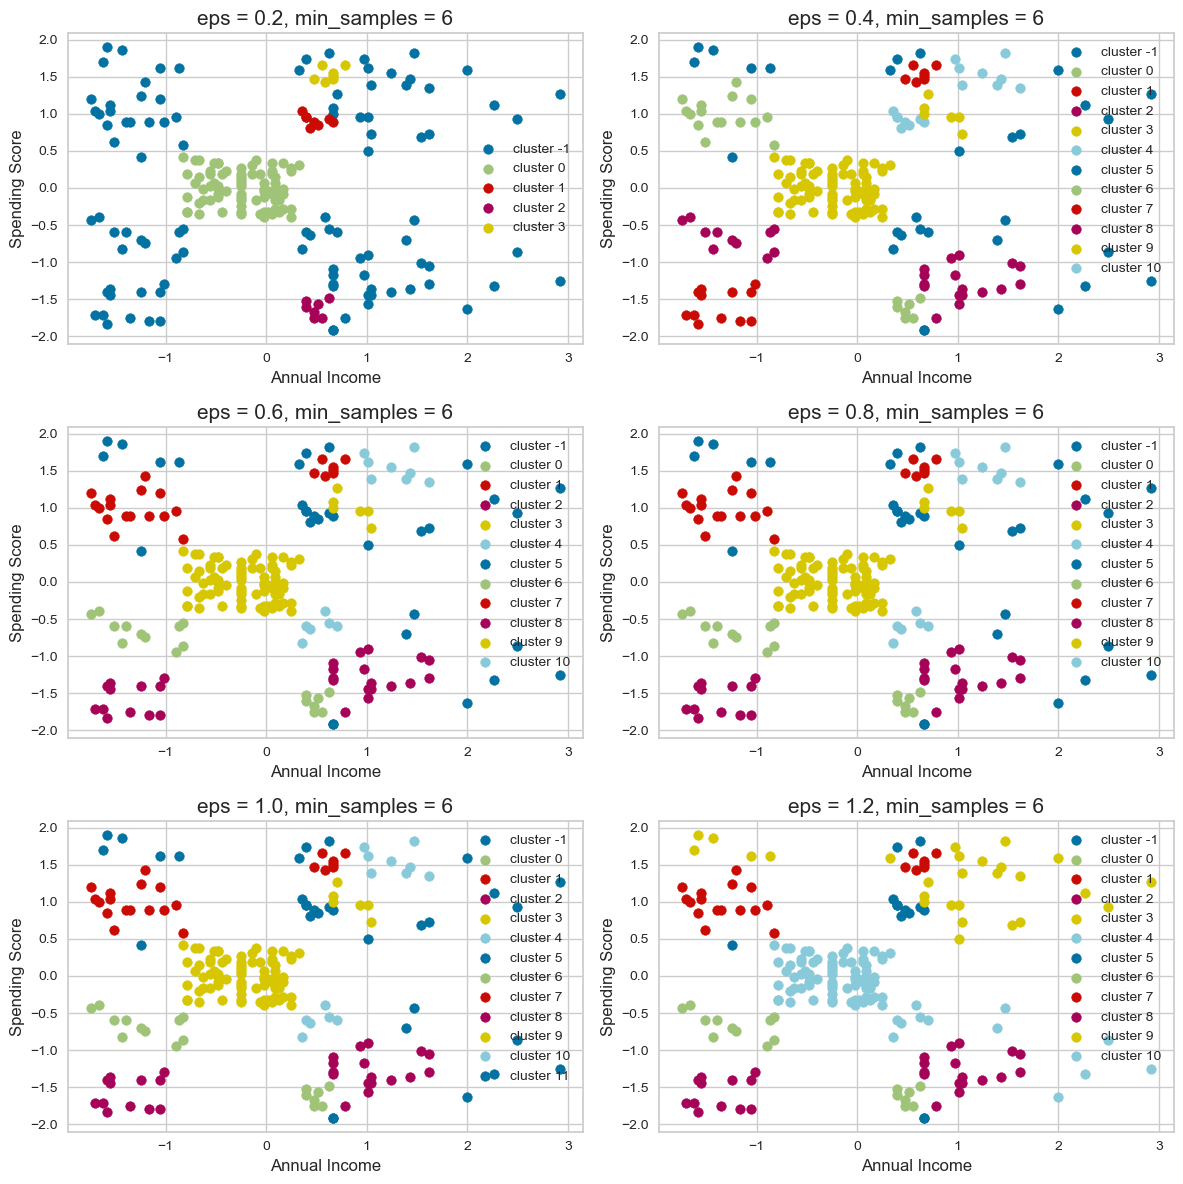

In [141]:
f, ax = plt.subplots(3, 2)
f.set_size_inches((12, 12))

for i in range(6):
    eps = 0.2 * (i + 1)
    min_samples = 6

    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(dbscan_df)
    dbscan_df['cluster'] = model.fit_predict(dbscan_df)

    for j in range(-1, dbscan_df['cluster'].max() + 1):
        ax[i // 2, i % 2].scatter(dbscan_df.loc[dbscan_df['cluster'] == j, 0], dbscan_df.loc[dbscan_df['cluster'] == j, 1], 
                        label = 'cluster ' + str(j))

    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('eps = %.1f, min_samples = %d'%(eps, min_samples), size = 15)
    ax[i // 2, i % 2].set_xlabel('Annual Income', size = 12)
    ax[i // 2, i % 2].set_ylabel('Spending Score', size = 12)
plt.tight_layout()
plt.show()

### 2-3-2 min_samples = 8

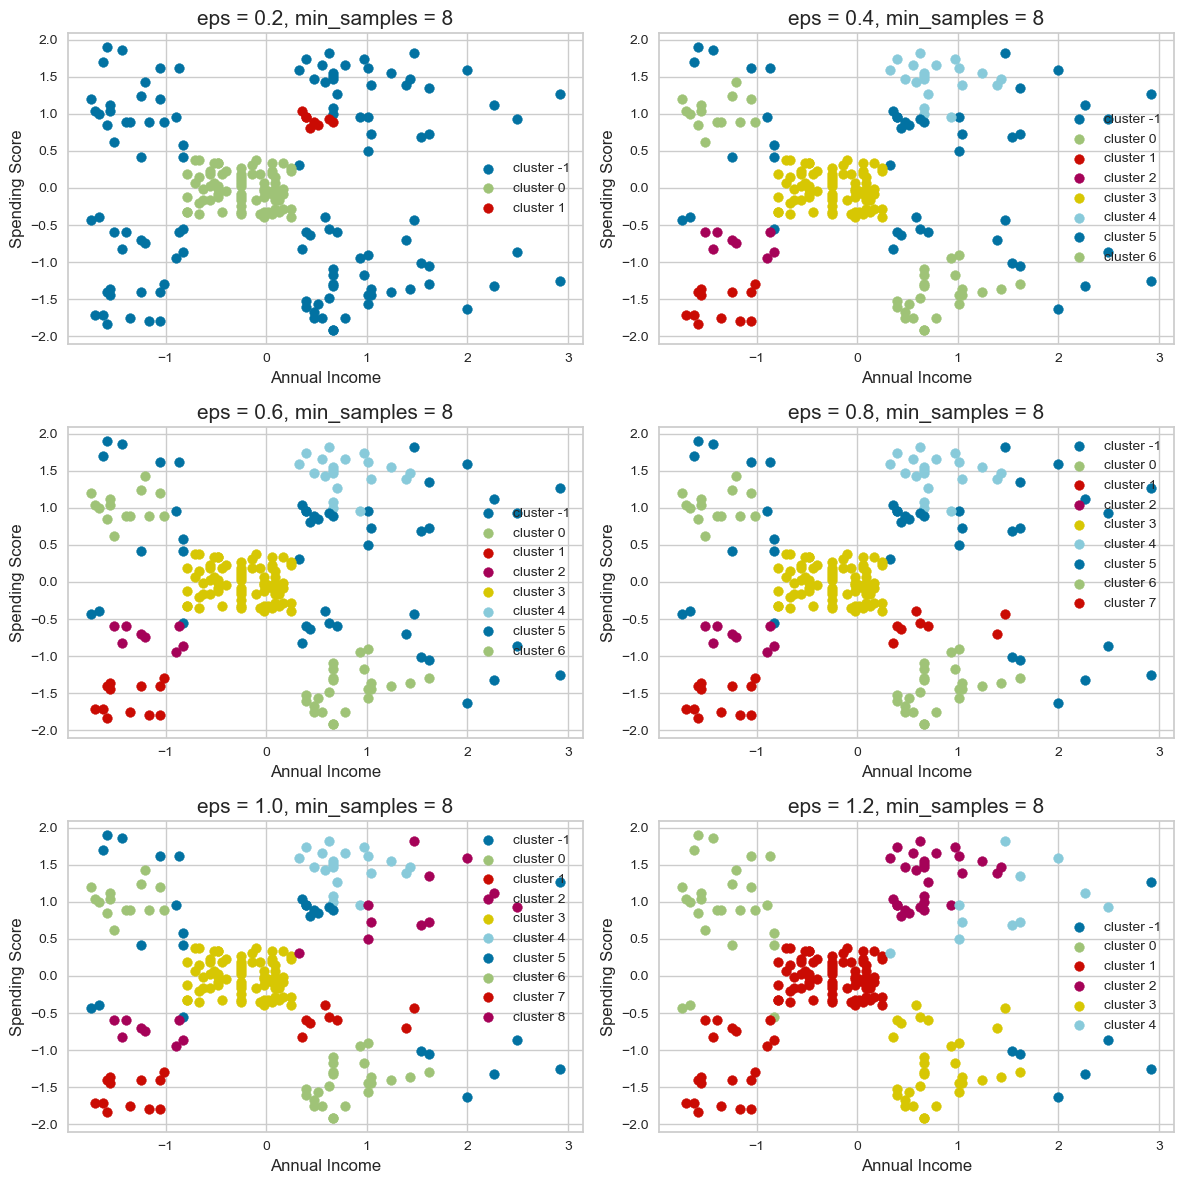

In [142]:
f, ax = plt.subplots(3, 2)
f.set_size_inches((12, 12))

for i in range(6):
    eps = 0.2 * (i + 1)
    min_samples = 8

    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(dbscan_df)
    dbscan_df['cluster'] = model.fit_predict(dbscan_df)

    for j in range(-1, dbscan_df['cluster'].max() + 1):
        ax[i // 2, i % 2].scatter(dbscan_df.loc[dbscan_df['cluster'] == j, 0], dbscan_df.loc[dbscan_df['cluster'] == j, 1], 
                        label = 'cluster ' + str(j))

    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('eps = %.1f, min_samples = %d'%(eps, min_samples), size = 15)
    ax[i // 2, i % 2].set_xlabel('Annual Income', size = 12)
    ax[i // 2, i % 2].set_ylabel('Spending Score', size = 12)
plt.tight_layout()
plt.show()

### 2-3-3 min_samples = 10

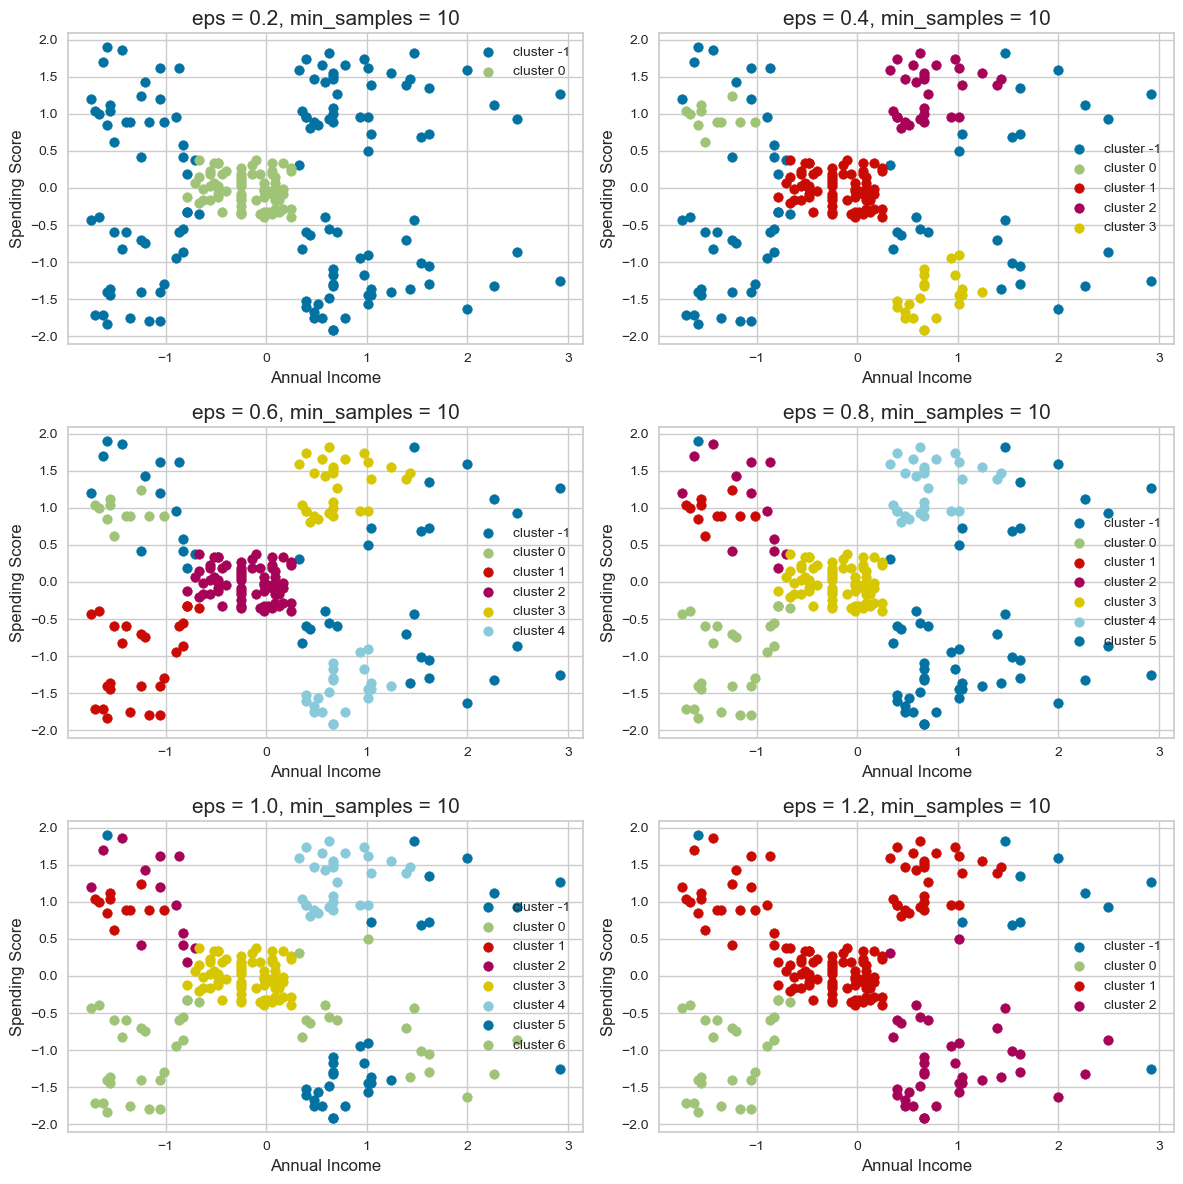

In [148]:
f, ax = plt.subplots(3, 2)
f.set_size_inches((12, 12))

for i in range(6):
    eps = 0.2 * (i + 1)
    min_samples = 10

    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(dbscan_df)
    dbscan_df['cluster'] = model.fit_predict(dbscan_df)

    for j in range(-1, dbscan_df['cluster'].max() + 1):
        ax[i // 2, i % 2].scatter(dbscan_df.loc[dbscan_df['cluster'] == j, 0], dbscan_df.loc[dbscan_df['cluster'] == j, 1], 
                        label = 'cluster ' + str(j))

    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('eps = %.1f, min_samples = %d'%(eps, min_samples), size = 15)
    ax[i // 2, i % 2].set_xlabel('Annual Income', size = 12)
    ax[i // 2, i % 2].set_ylabel('Spending Score', size = 12)
plt.tight_layout()
plt.show()

### 2-3-4 min_samples = 12

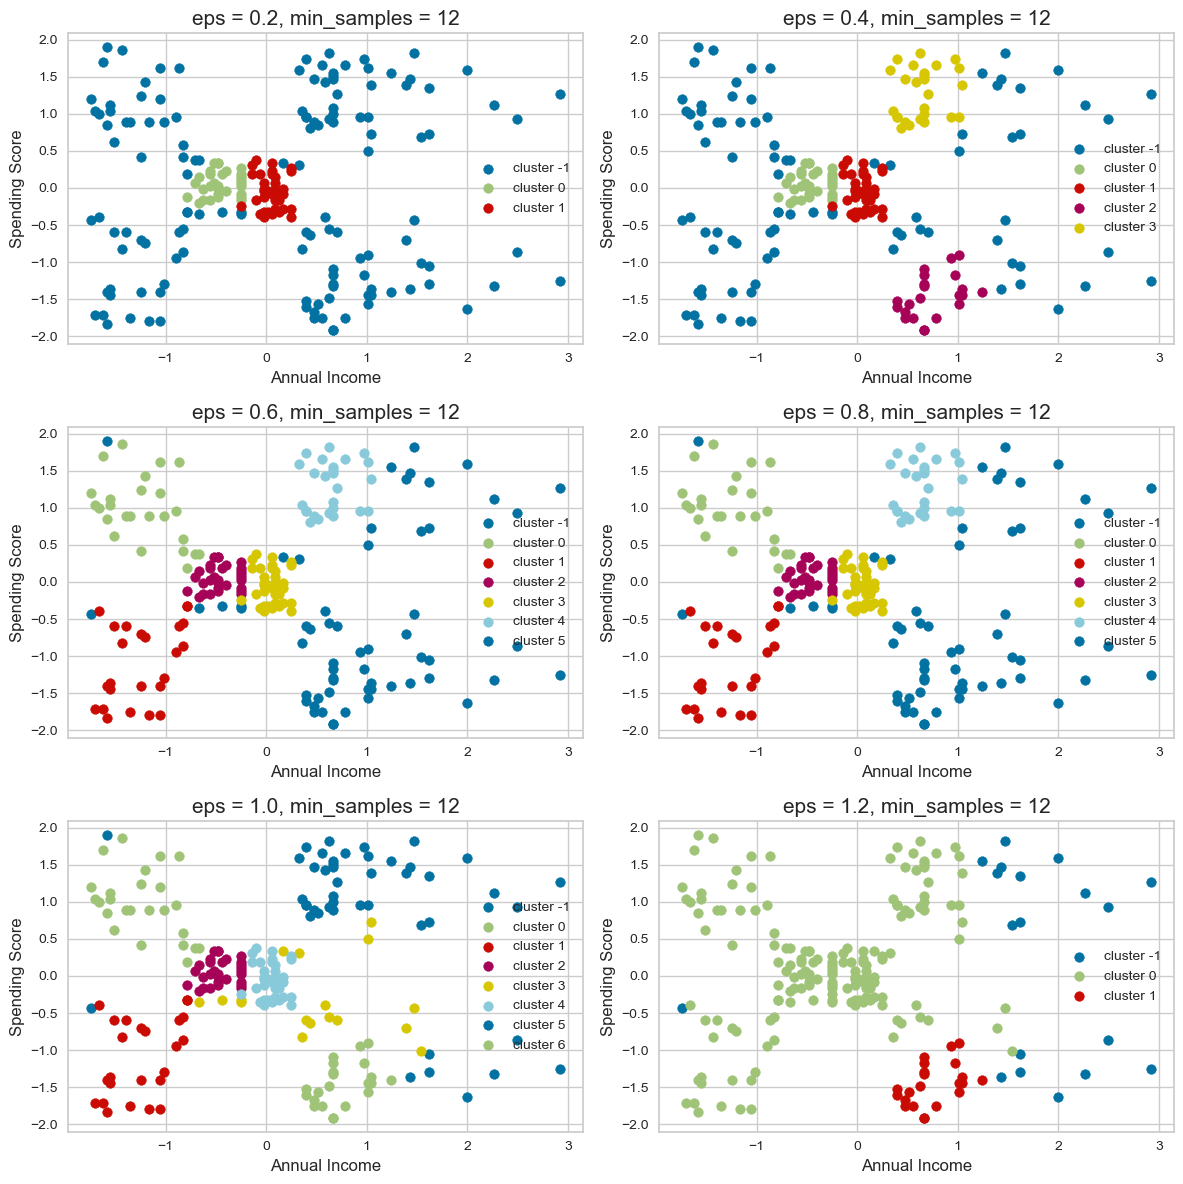

In [161]:
f, ax = plt.subplots(3, 2)
f.set_size_inches((12, 12))

for i in range(6):
    eps = 0.2 * (i + 1)
    min_samples = 12

    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(dbscan_df)
    dbscan_df['cluster'] = model.fit_predict(dbscan_df)

    for j in range(-1, dbscan_df['cluster'].max() + 1):
        ax[i // 2, i % 2].scatter(dbscan_df.loc[dbscan_df['cluster'] == j, 0], dbscan_df.loc[dbscan_df['cluster'] == j, 1], 
                        label = 'cluster ' + str(j))

    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('eps = %.1f, min_samples = %d'%(eps, min_samples), size = 15)
    ax[i // 2, i % 2].set_xlabel('Annual Income', size = 12)
    ax[i // 2, i % 2].set_ylabel('Spending Score', size = 12)
plt.tight_layout()
plt.show()

위의 결과들을 살펴보면 min_samples의 값이 8과 10에서 가장 군집화가 어느정도 잘 되었다고 판단할 수 있다. 특히 그중에서 eps = 0.6, min_samples = 10의 경우가 가장 5개의 군집으로 잘 분류했다고 볼 수 있다.